In [1]:
suppressPackageStartupMessages({

    library(VariantAnnotation)
    library(tidyverse)
    library(magrittr)
    library(here)
    library(bdkn)
    library(rtracklayer)

})

In [2]:
source(here("src/utils.R"))

In [3]:
gt <- read_gt(here("data/vcf/merged_full.vcf.gz"))

In [4]:
emh_ages <- tibble(
    emh = c("ustishim", "bichon", "kk1", "loschbour", "mota"),
    age = c(45000, 13665, 9720, 8050, 4500)
)
emh_ages

emh,age
ustishim,45000
bichon,13665
kk1,9720
loschbour,8050
mota,4500


In [5]:
emh <- c("kk1", "mota", "bichon", "loschbour", "ustishim")

In [6]:
archaic <- c("spy1", "mez2", "comb_neand", "denisova8", "denisova8sub", "elsidron1", "elsidron2")

In [7]:
pops <- tibble(
    name = c(str_subset(colnames(gt), "^S_"), "reference", "a00"),
    pop = case_when(
        name == "reference" ~ "reference",
        name %in% c("S_Burmese-1", "S_Thai-1", "S_Han-2", "S_Dai-2", "S_Punjabi-1", "S_Papuan-2", "S_Karitiana-1") ~ "EastEur",
        name %in% c("S_BedouinB-1", "S_Turkish-1", "S_French-1", "S_Finnish-2", "S_Sardinian-1", "S_Saami-2") ~ "WestEur",
        TRUE ~ "Africa"
    )
)

In [8]:
pops

name,pop
S_BedouinB_1,Africa
S_Turkish_1,Africa
S_French_1,Africa
S_Burmese_1,Africa
S_Thai_1,Africa
S_Finnish_2,Africa
S_Sardinian_1,Africa
S_Han_2,Africa
S_Dai_2,Africa
S_Punjabi_1,Africa


In [9]:
site_patterns <- function(df, w, x, y, z) {
    tibble(
        a = as.integer(df[[w]] == df[[x]] & df[[y]] == df[[z]] & df[[w]] != df[[y]]),
        b = as.integer(df[[w]] == df[[z]] & df[[x]] == df[[y]] & df[[w]] != df[[x]]),
        c = as.integer(df[[w]] == df[[y]] & df[[x]] == df[[z]] & df[[w]] != df[[z]]),
        d = as.integer(df[[w]] == df[[x]] & df[[w]] == df[[z]] & df[[w]] != df[[y]]),
        e = as.integer(df[[w]] == df[[x]] & df[[w]] == df[[y]] & df[[w]] != df[[z]]),
        f = as.integer(df[[w]] == df[[y]] & df[[w]] == df[[z]] & df[[w]] != df[[x]])
    )
}

In [10]:
sum_patterns <- function(gt, w, x, y, z) {
    df <- gt[, c(w, x, y, z)] %>% .[complete.cases(.), ]
    site_patterns(df, w, x, y, z) %>% summarise_all(sum) %>% mutate(total = nrow(df))
}

# Estimating $T_{MRCA}$ of an African lineage and non-Africans ($T_{AR}$)

In [11]:
tAR_emh <- 
    map_dfr(filter(pops, pop != "Africa")$name, function(ref) {
        map_dfr(filter(pops, pop == "Africa")$name, function(afr) {
            map_dfr(emh, function(emh) {
                sum_patterns(gt, w = "chimp", x = afr, y = ref, z = emh) %>%
                    mutate(afr = afr, ref = ref, emh = emh)
            })
        })
    }) %>%
    inner_join(emh_ages) %>% 
    inner_join(pops, by = c("ref" = "name")) %>%
    mutate(
        muts_per_year = (d - e) / age,
        mut_rate = muts_per_year / total,
        tmrca_ad = (a + d) / (mut_rate * total),
        tmrca_f = f / (mut_rate * total),
        tmrca_avg = (tmrca_ad + tmrca_f) / 2
    )

Joining, by = "emh"


All SNPs:

In [17]:
filter(tAR_emh, emh == "ustishim") %>%
    group_by(afr, emh) %>%
    summarise_if(is.numeric, mean) %>%
    select(afr, emh, mut_rate, starts_with("tmrca"), everything())

afr,emh,mut_rate,tmrca_ad,tmrca_f,tmrca_avg,a,b,c,d,e,f,total,age,muts_per_year
a00,ustishim,7.215452e-10,278438.01,238463.69,258450.85,1003.0000,2.142857,8.214286,209.3571,12.64286,1037.5000,6058128,45000,0.004371429
S_Dinka-1,ustishim,7.308697e-10,70931.24,69158.78,70045.01,102.7857,2.000000,8.857143,213.6429,12.50000,307.5000,6115501,45000,0.004469841
S_Gambian-1,ustishim,7.322131e-10,71869.30,68612.18,70240.74,107.5714,1.214286,8.785714,214.6429,12.50000,306.6429,6134590,45000,0.004492063
S_Ju_hoan_North-1,ustishim,7.277401e-10,104533.24,95381.59,99957.41,251.7857,2.571429,8.857143,213.4286,12.50000,423.5000,6135173,45000,0.004465079
S_Mandenka-1,ustishim,7.257687e-10,74276.64,69760.05,72018.35,117.4286,1.214286,8.785714,213.0714,12.50000,309.5714,6141029,45000,0.004457143
S_Mbuti-1,ustishim,7.282165e-10,73606.67,74888.90,74247.79,114.7857,1.214286,8.785714,213.7143,12.50000,333.2143,6139982,45000,0.004471429
S_Yoruba-2,ustishim,7.279030e-10,73462.09,69549.07,71505.58,113.5000,1.214286,8.571429,212.8571,12.50000,307.9286,6116311,45000,0.004452381


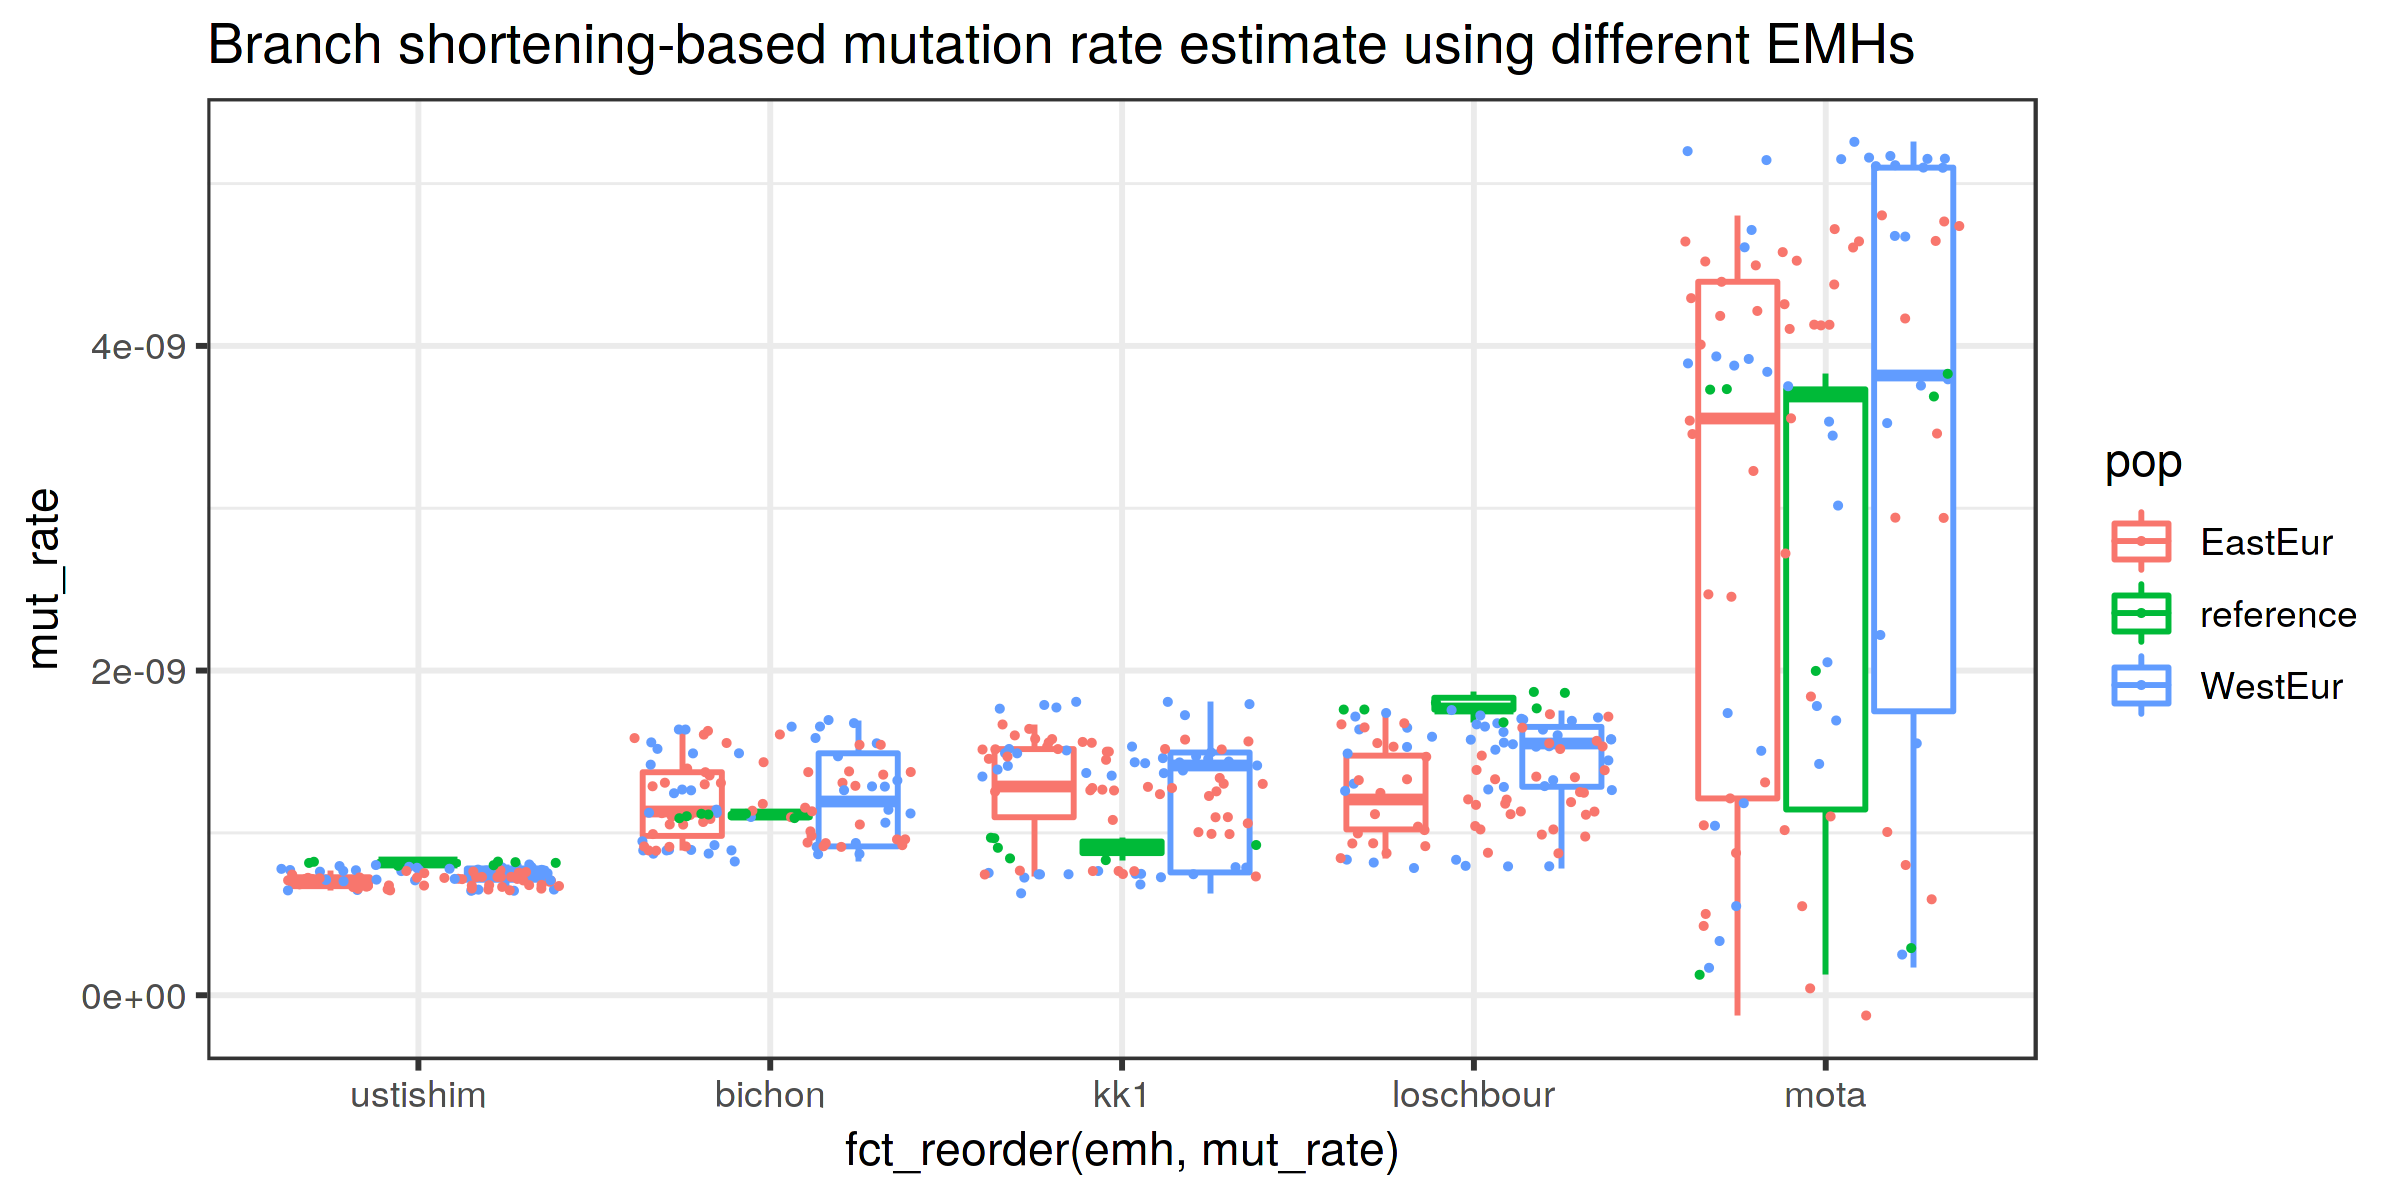

In [38]:
set_dim(8, 4, 300)

tAR_emh %>%
ggplot(aes(fct_reorder(emh, mut_rate), mut_rate, color = pop)) +
    geom_boxplot(outlier.shape = NA) +
    geom_jitter(size = 0.25) +
    ggtitle("Branch shortening-based mutation rate estimate using different EMHs") +
    theme_bw()

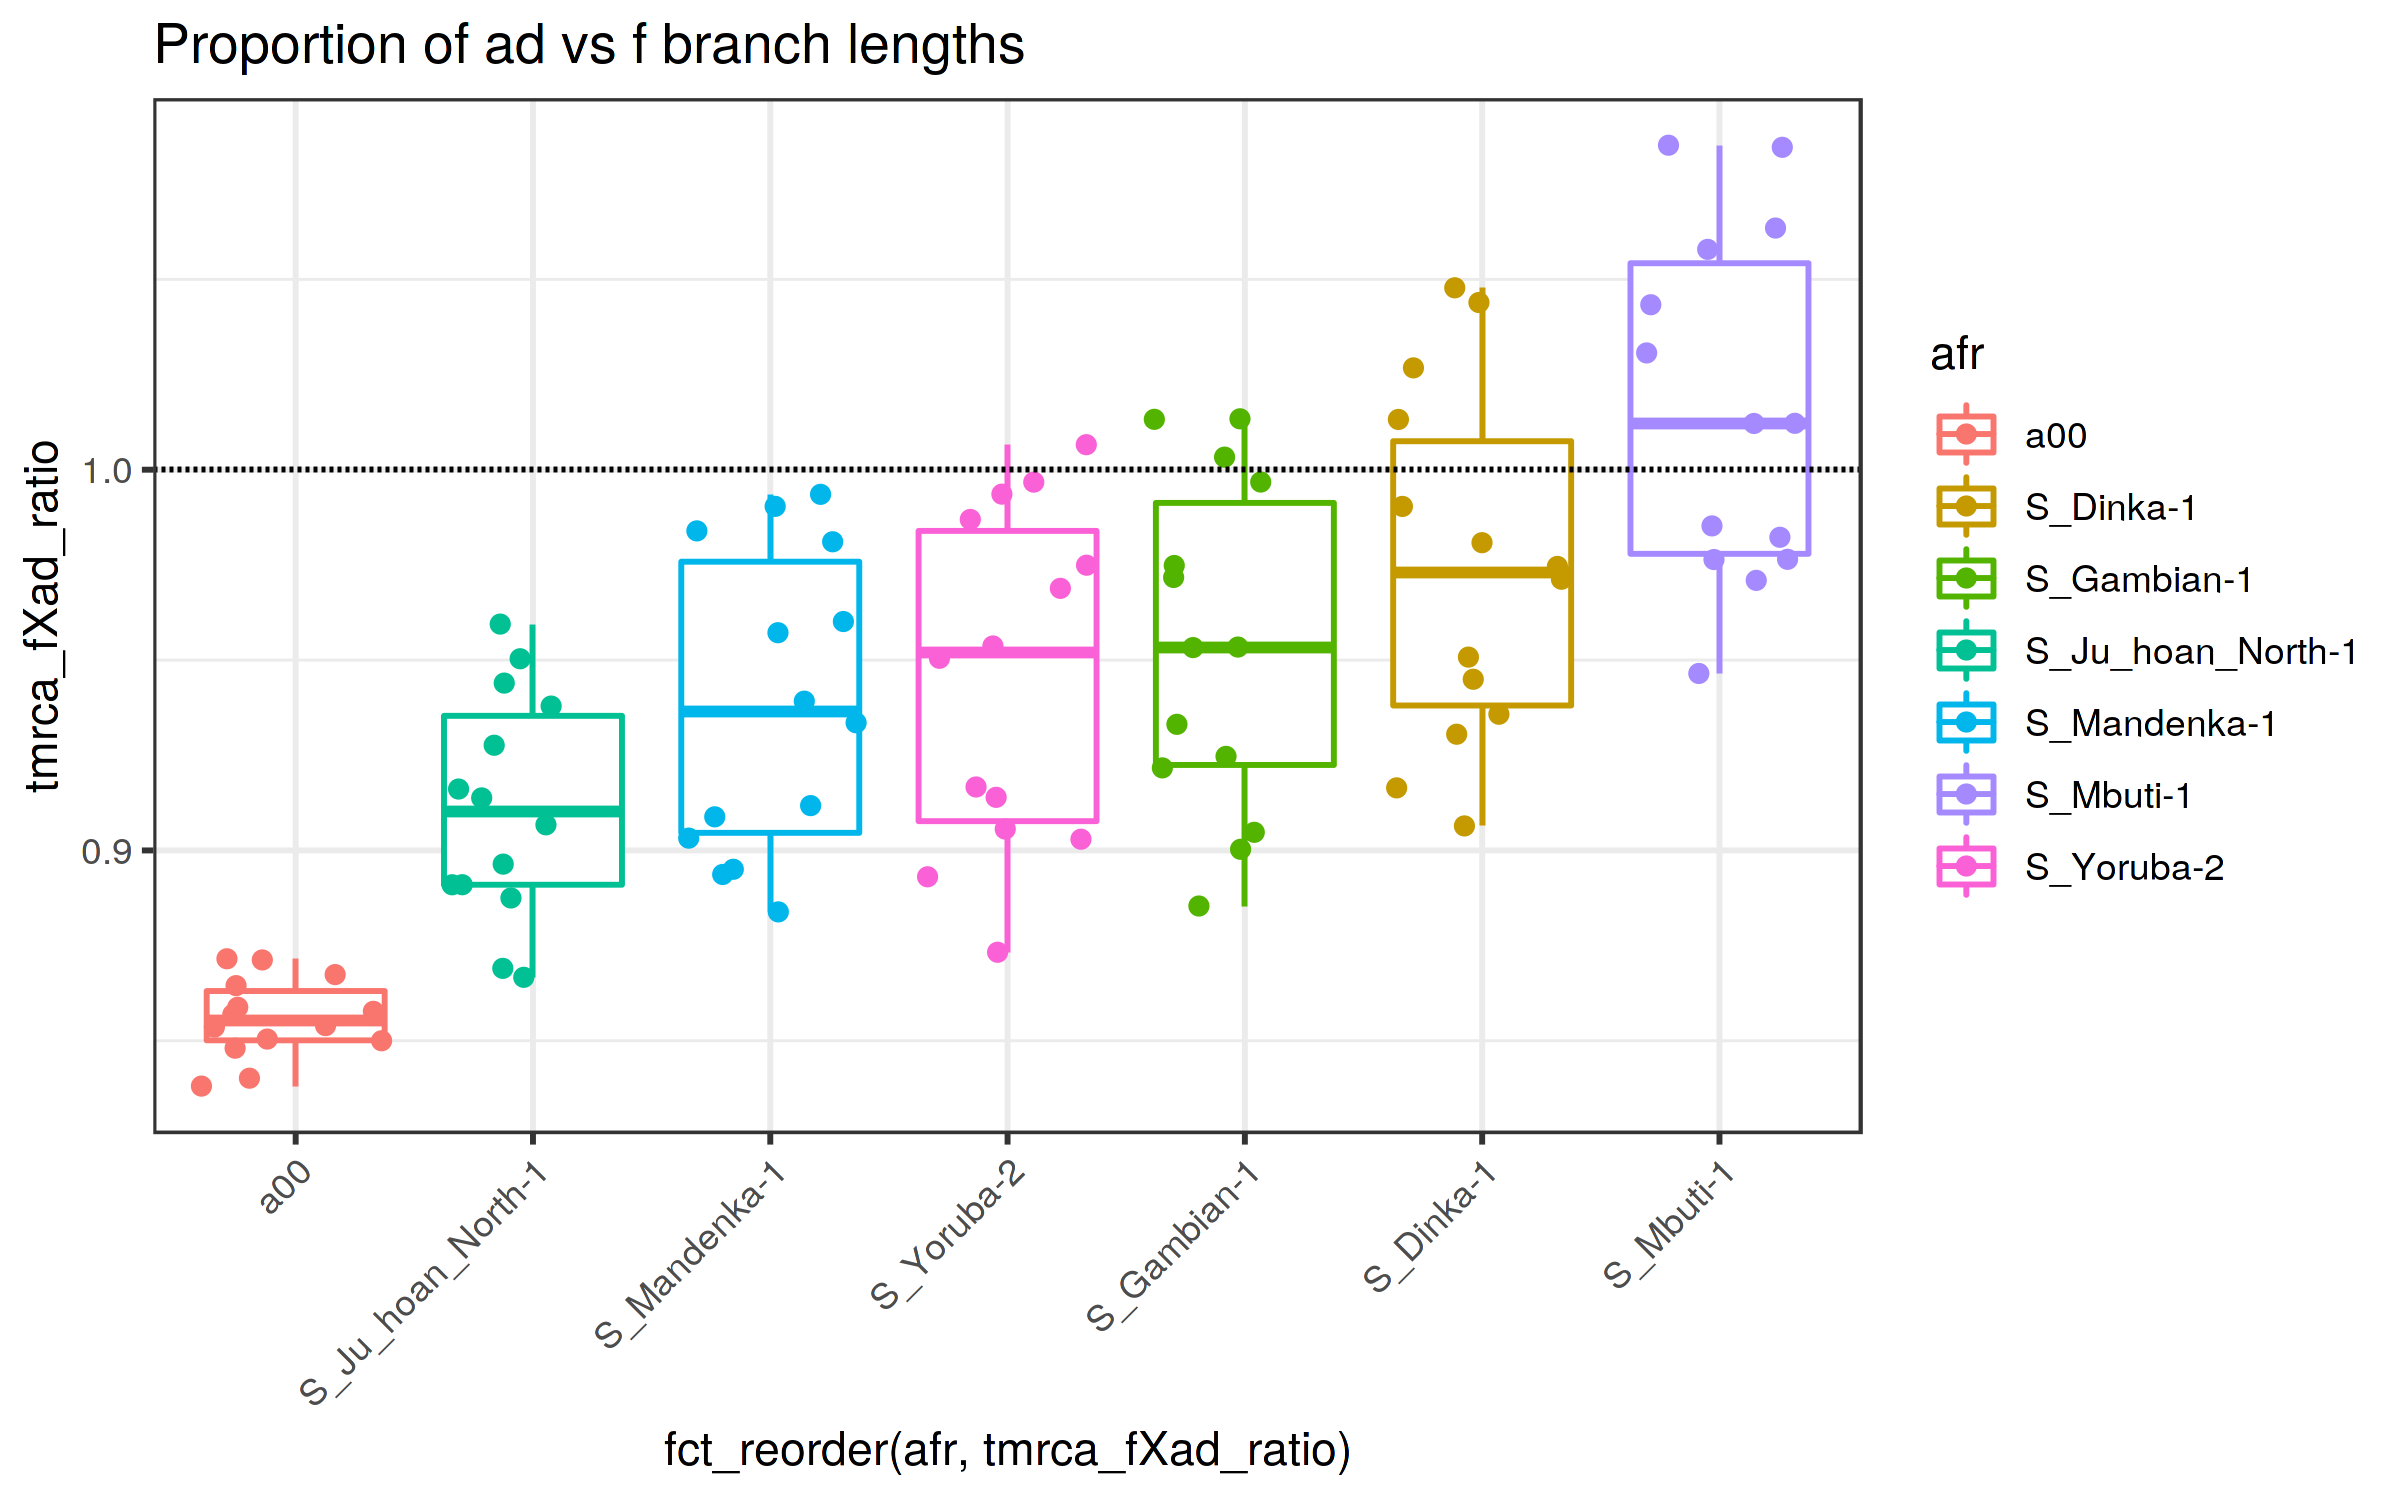

In [20]:
set_dim(8, 5, 300)

tAR_emh %>%
    filter(emh == "ustishim") %>%
    mutate(tmrca_fXad_ratio = tmrca_f / tmrca_ad) %>%
ggplot(aes(fct_reorder(afr, tmrca_fXad_ratio), tmrca_fXad_ratio, color = afr)) +
    geom_boxplot() +
    geom_jitter() +
    geom_hline(yintercept = 1, linetype = 2) +
    theme_bw() +
    theme(axis.text.x = element_text(hjust = 1, angle = 45)) +
    ggtitle("Proportion of ad vs f branch lengths")

TV-only SNPs:

In [13]:
group_by(a00, emh) %>% summarise_if(is.numeric, mean)

emh,a,d,e,f,chimp_emh,hum_der,total,age,muts_per_year,mut_rate,tmrca_ad,tmrca_f,tmrca_avg,tmrca_ratio
bichon,182.25,47.75,32.40,215.30,1.9,43656.25,3092503,13665,0.0011233077,3.632419e-10,Inf,Inf,Inf,NaN
kk1,281.35,67.00,55.10,324.90,3.3,64823.20,4806536,9720,0.0012242798,2.546768e-10,767137.3,731194.2,749165.7,1.072197
loschbour,344.75,92.65,61.80,397.65,3.9,77859.90,5893830,8050,0.0038322981,6.501212e-10,136380.7,125500.2,130940.4,1.099976
mota,278.70,88.40,84.70,345.45,0.1,67619.75,5149427,4500,0.0008222222,1.596792e-10,Inf,Inf,Inf,NaN
ustishim,337.00,92.55,21.35,397.40,0.1,78640.75,5937346,45000,0.0015822222,2.664665e-10,275920.7,256068.2,265994.5,1.080894


Lippold all SNPs:

In [36]:
group_by(a00, emh) %>% summarise_if(is.numeric, mean)

emh,a,d,e,f,chimp_emh,hum_der,total,age,muts_per_year,mut_rate,tmrca_ad,tmrca_f,tmrca_avg,tmrca_ratio
bichon,52.80,27.90,16.75,59.95,0.45,13014.60,285545.0,13665,0.0008159532,2.853818e-09,97132.95,73056.74,85094.85,1.346523
kk1,72.10,34.10,25.00,75.75,0.45,17793.55,412587.7,9720,0.0009362140,2.267315e-09,144036.41,105651.98,124844.19,1.402212
loschbour,84.25,46.95,24.70,83.80,1.40,20304.90,484517.7,8050,0.0027639752,5.698763e-09,73822.94,50220.24,62021.59,1.565685
mota,58.75,44.30,25.50,75.20,0.00,17740.90,423599.1,4500,0.0041777778,9.855787e-09,20257.53,13258.17,16757.85,1.370089
ustishim,81.90,45.50,10.25,81.75,0.45,20729.00,491521.3,45000,0.0007833333,1.592648e-09,145777.40,89545.05,117661.22,1.558411


Lippold all SNPs - WGS mutation rate and A00 divergence:

In [38]:
group_by(a00, emh) %>% summarise_if(is.numeric, mean)

emh,a,d,e,f,chimp_emh,hum_der,total,age,muts_per_year,mut_rate,tmrca_ad,tmrca_f,tmrca_avg,tmrca_ratio
bichon,52.80,27.90,16.75,59.95,0.45,13014.60,285545.0,13665,0.0008159532,2.853818e-09,381848.3,283714.8,332781.6,1.346523
kk1,72.10,34.10,25.00,75.75,0.45,17793.55,412587.7,9720,0.0009362140,2.267315e-09,347814.9,248105.9,297960.4,1.402212
loschbour,84.25,46.95,24.70,83.80,1.40,20304.90,484517.7,8050,0.0027639752,5.698763e-09,365860.4,233725.1,299792.7,1.565685
mota,58.75,44.30,25.50,75.20,0.00,17740.90,423599.1,4500,0.0041777778,9.855787e-09,328701.4,239900.3,284300.8,1.370089
ustishim,81.90,45.50,10.25,81.75,0.45,20729.00,491521.3,45000,0.0007833333,1.592648e-09,350199.0,224758.2,287478.6,1.558411


### Final estimates based on the Ust'-Ishim individual

All SNPs:

In [23]:
tAR <- filter(tAR_emh, emh == "ustishim") %>%
    select(afr, mut_rate, tmrca_ad, tmrca_f, tmrca_avg) %>%
    group_by(afr) %>%
    summarise_all(mean)
tAR

afr,mut_rate,tmrca_ad,tmrca_f,tmrca_avg
a00,7.215452e-10,278438.01,238463.69,258450.85
S_Dinka-1,7.308697e-10,70931.24,69158.78,70045.01
S_Gambian-1,7.322131e-10,71869.30,68612.18,70240.74
S_Ju_hoan_North-1,7.277401e-10,104533.24,95381.59,99957.41
S_Mandenka-1,7.257687e-10,74276.64,69760.05,72018.35
S_Mbuti-1,7.282165e-10,73606.67,74888.90,74247.79
S_Yoruba-2,7.279030e-10,73462.09,69549.07,71505.58


TV-only SNPs:

In [14]:
t_a00 <- a00 %>%
    filter(emh == "ustishim") %>%
    select(mut_rate, tmrca_ad, tmrca_f, tmrca_avg) %>%
    summarise_all(mean)

t_a00

mut_rate,tmrca_ad,tmrca_f,tmrca_avg
2.664665e-10,275920.7,256068.2,265994.5


Lippold all SNPs:

In [14]:
t_a00 <- a00 %>%
    filter(emh == "ustishim") %>%
    select(mut_rate, tmrca_ad, tmrca_f, tmrca_avg) %>%
    summarise_all(mean)

t_a00

mut_rate,tmrca_ad,tmrca_f,tmrca_avg
1.592648e-09,145777.4,89545.05,117661.2


Lippold all SNPs - WGS mutation rate and A00 divergence:

In [44]:
t_a00 <- a00 %>%
    filter(emh == "ustishim") %>%
    select(mut_rate, tmrca_ad, tmrca_f, tmrca_avg) %>%
    summarise_all(mean)

t_a00

mut_rate,tmrca_ad,tmrca_f,tmrca_avg
1.592648e-09,350199,224758.2,287478.6


# Estimating the $\alpha$ parameter

## Method 1

$$\frac{T_a}{T_a + T_d + T_e} = \frac{T_{NM}}{T_{NM} + 2T_{AR}} = \frac{(\alpha - 1)T_{AR}}{(\alpha - 1)T_{AR} + 2T_{AR}} = \frac{\alpha - 1}{\alpha + 1} = p \implies \alpha = \frac{1 + p}{1 - p}$$

In [24]:
tNR_counts <-
    map_dfr(filter(pops, pop != "Africa")$name, function(ref) {
        map_dfr(filter(pops, pop == "Africa")$name, function(afr) {
            map_dfr(archaic, function(arch) {
                if (!arch %in% colnames(gt)) return(NULL)
                sum_patterns(gt, w = "chimp", x = arch, y = ref, z = afr) %>%
                    mutate(ref = ref, archaic = arch, afr = afr)
            })
        })
    })

In [26]:
tNR <-
    inner_join(tNR_counts, tAR) %>%
    mutate(p = a / (a + d + e),
           alpha = (1 + p) / (1 - p),
           tmrca_arch = tmrca_avg * alpha) %>%
    select(archaic, afr, ref, tmrca_arch, alpha, mut_rate, tmrca_ad, tmrca_f, tmrca_avg, everything())

Joining, by = "afr"


In [32]:
tNR %>%
    group_by(archaic, afr) %>%
    summarise_if(is.numeric, mean) %>%
    arrange(afr)

archaic,afr,tmrca_arch,alpha,mut_rate,tmrca_ad,tmrca_f,tmrca_avg,a,b,c,d,e,f,total,p
comb_neand,a00,368269.0,1.424909,7.215452e-10,278438.01,238463.69,258450.85,84.50000,10.5000000,3.2857143,173.14286,224.785714,272.7857,1394024.3,0.1752117
denisova8,a00,630747.7,2.440494,7.215452e-10,278438.01,238463.69,258450.85,537.92857,22.8571429,11.7142857,309.07143,438.000000,648.4286,2591666.2,0.4186561
denisova8sub,a00,586483.3,2.269226,7.215452e-10,278438.01,238463.69,258450.85,253.50000,10.9285714,6.8571429,155.00000,244.785714,313.3571,1444340.2,0.3881476
mez2,a00,369937.3,1.431364,7.215452e-10,278438.01,238463.69,258450.85,35.00000,7.0714286,1.5000000,72.35714,90.071429,140.5714,554168.8,0.1773740
spy1,a00,396443.1,1.533921,7.215452e-10,278438.01,238463.69,258450.85,15.78571,4.6428571,0.3571429,23.57143,35.714286,174.3571,231360.6,0.2105708
comb_neand,S_Dinka-1,284854.5,4.066735,7.308697e-10,70931.24,69158.78,70045.01,203.50000,1.6428571,1.2857143,56.00000,77.214286,275.3571,1405220.4,0.6047239
denisova8,S_Dinka-1,550689.4,7.861937,7.308697e-10,70931.24,69158.78,70045.01,758.00000,5.0000000,3.7857143,102.14286,119.500000,662.0714,2611465.3,0.7738560
denisova8sub,S_Dinka-1,472761.6,6.749397,7.308697e-10,70931.24,69158.78,70045.01,359.35714,5.0000000,1.9285714,55.14286,70.785714,323.1429,1455537.3,0.7408094
mez2,S_Dinka-1,323382.4,4.616780,7.308697e-10,70931.24,69158.78,70045.01,87.42857,1.0714286,0.5000000,22.07143,26.571429,143.5000,558643.9,0.6429636
spy1,S_Dinka-1,208347.1,2.974475,7.308697e-10,70931.24,69158.78,70045.01,29.71429,0.7142857,0.3571429,10.50000,20.000000,176.3571,233302.0,0.4950171


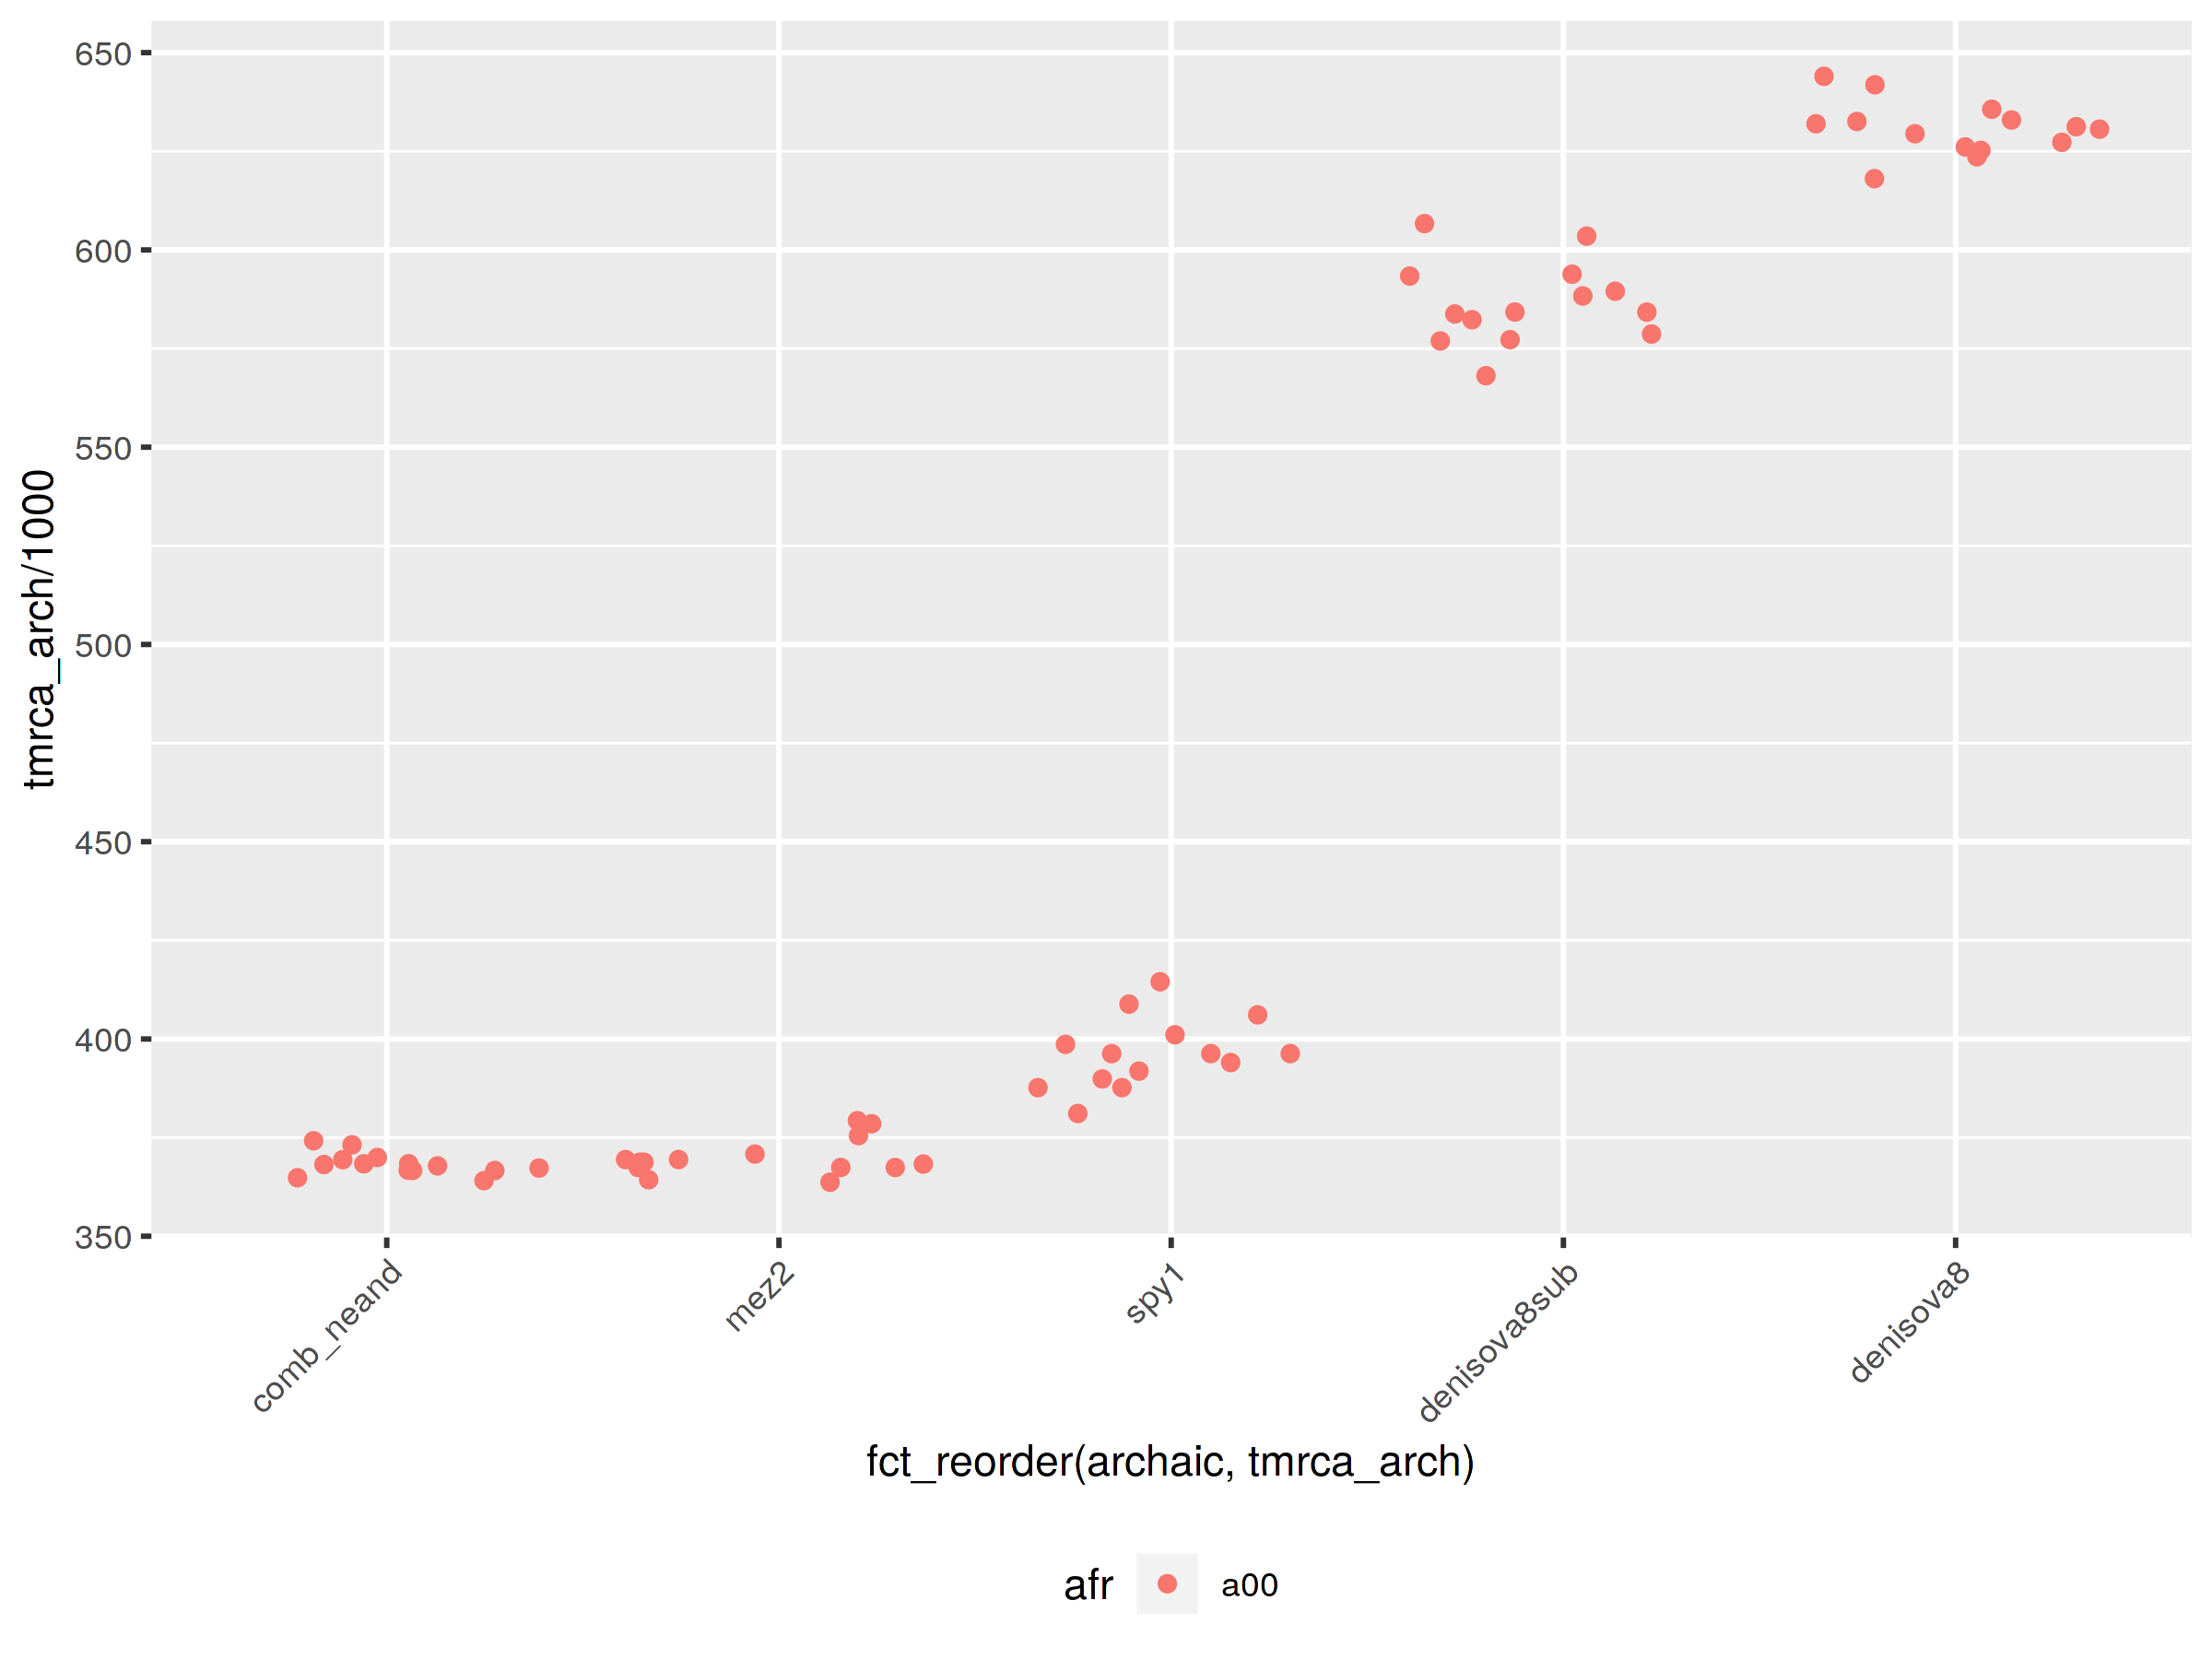

In [47]:
set_dim(8, 6, 300)

tNR %>% filter(afr == "a00") %>% 
ggplot(aes(fct_reorder(archaic, tmrca_arch), tmrca_arch / 1000, color = afr)) +
    geom_jitter() +
    theme(legend.position = "bottom", axis.text.x = element_text(hjust = 1, angle = 45))

All SNPs:

In [48]:
tNR %>% filter(afr == "a00") %>% 
    group_by(archaic) %>%
    summarise_if(is.numeric, mean) %>%
    arrange(tmrca_arch)

archaic,tmrca_arch,alpha,mut_rate,tmrca_ad,tmrca_f,tmrca_avg,a,b,c,d,e,f,total,p
comb_neand,368269.0,1.424909,7.215452e-10,278438,238463.7,258450.9,84.50000,10.500000,3.2857143,173.14286,224.78571,272.7857,1394024.3,0.1752117
mez2,369937.3,1.431364,7.215452e-10,278438,238463.7,258450.9,35.00000,7.071429,1.5000000,72.35714,90.07143,140.5714,554168.8,0.1773740
spy1,396443.1,1.533921,7.215452e-10,278438,238463.7,258450.9,15.78571,4.642857,0.3571429,23.57143,35.71429,174.3571,231360.6,0.2105708
denisova8sub,586483.3,2.269226,7.215452e-10,278438,238463.7,258450.9,253.50000,10.928571,6.8571429,155.00000,244.78571,313.3571,1444340.2,0.3881476
denisova8,630747.7,2.440494,7.215452e-10,278438,238463.7,258450.9,537.92857,22.857143,11.7142857,309.07143,438.00000,648.4286,2591666.2,0.4186561


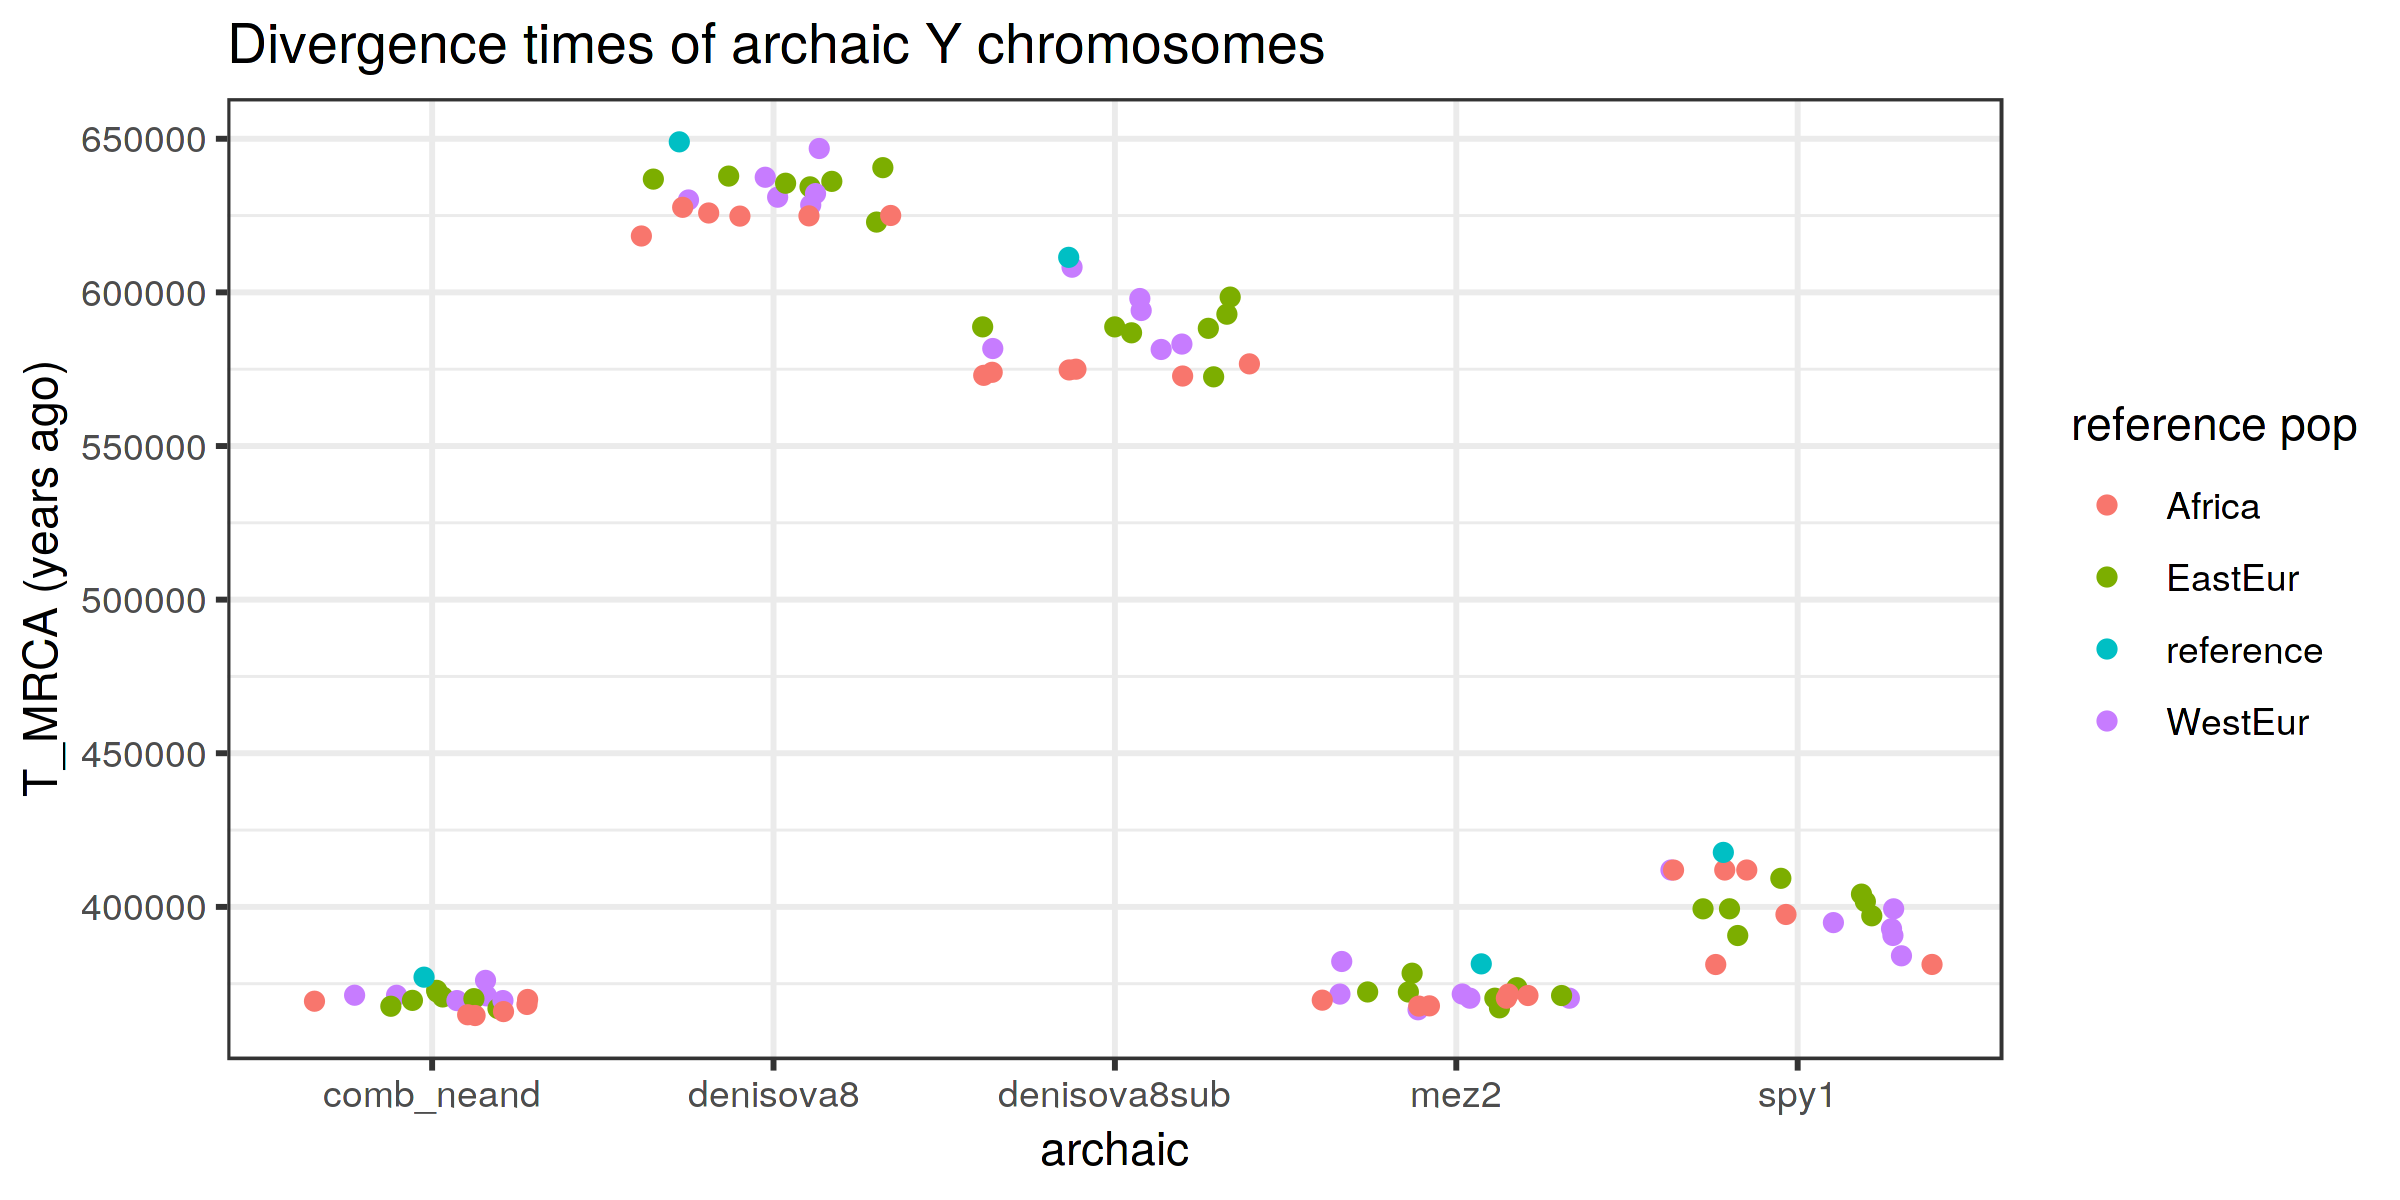

In [24]:
arch %>%
    ggplot(aes(archaic, tmrca_arch, color = pop)) +
    geom_jitter() +
    ylab("T_MRCA (years ago)") +
    guides(color = guide_legend("reference pop")) +
    ggtitle("Divergence times of archaic Y chromosomes") +
    theme_bw()

TV-only SNPs:

In [19]:
arch %>%
    group_by(archaic) %>%
    summarise_if(is.numeric, mean) %>%
    arrange(tmrca_arch)

archaic,a,d,e,f,total,p,alpha,tmrca_arch
mez2,10.80,25.75,30.65,26.85,541671.6,0.1608888,1.383694,368054.9
spy1,3.95,6.15,13.90,28.65,226763.8,0.1659212,1.398843,372084.4
comb_neand,30.40,59.20,85.15,67.35,1365402.0,0.1740555,1.421563,378128.0
denisova8,205.85,113.35,170.40,238.80,2539513.0,0.4206619,2.453204,652538.6


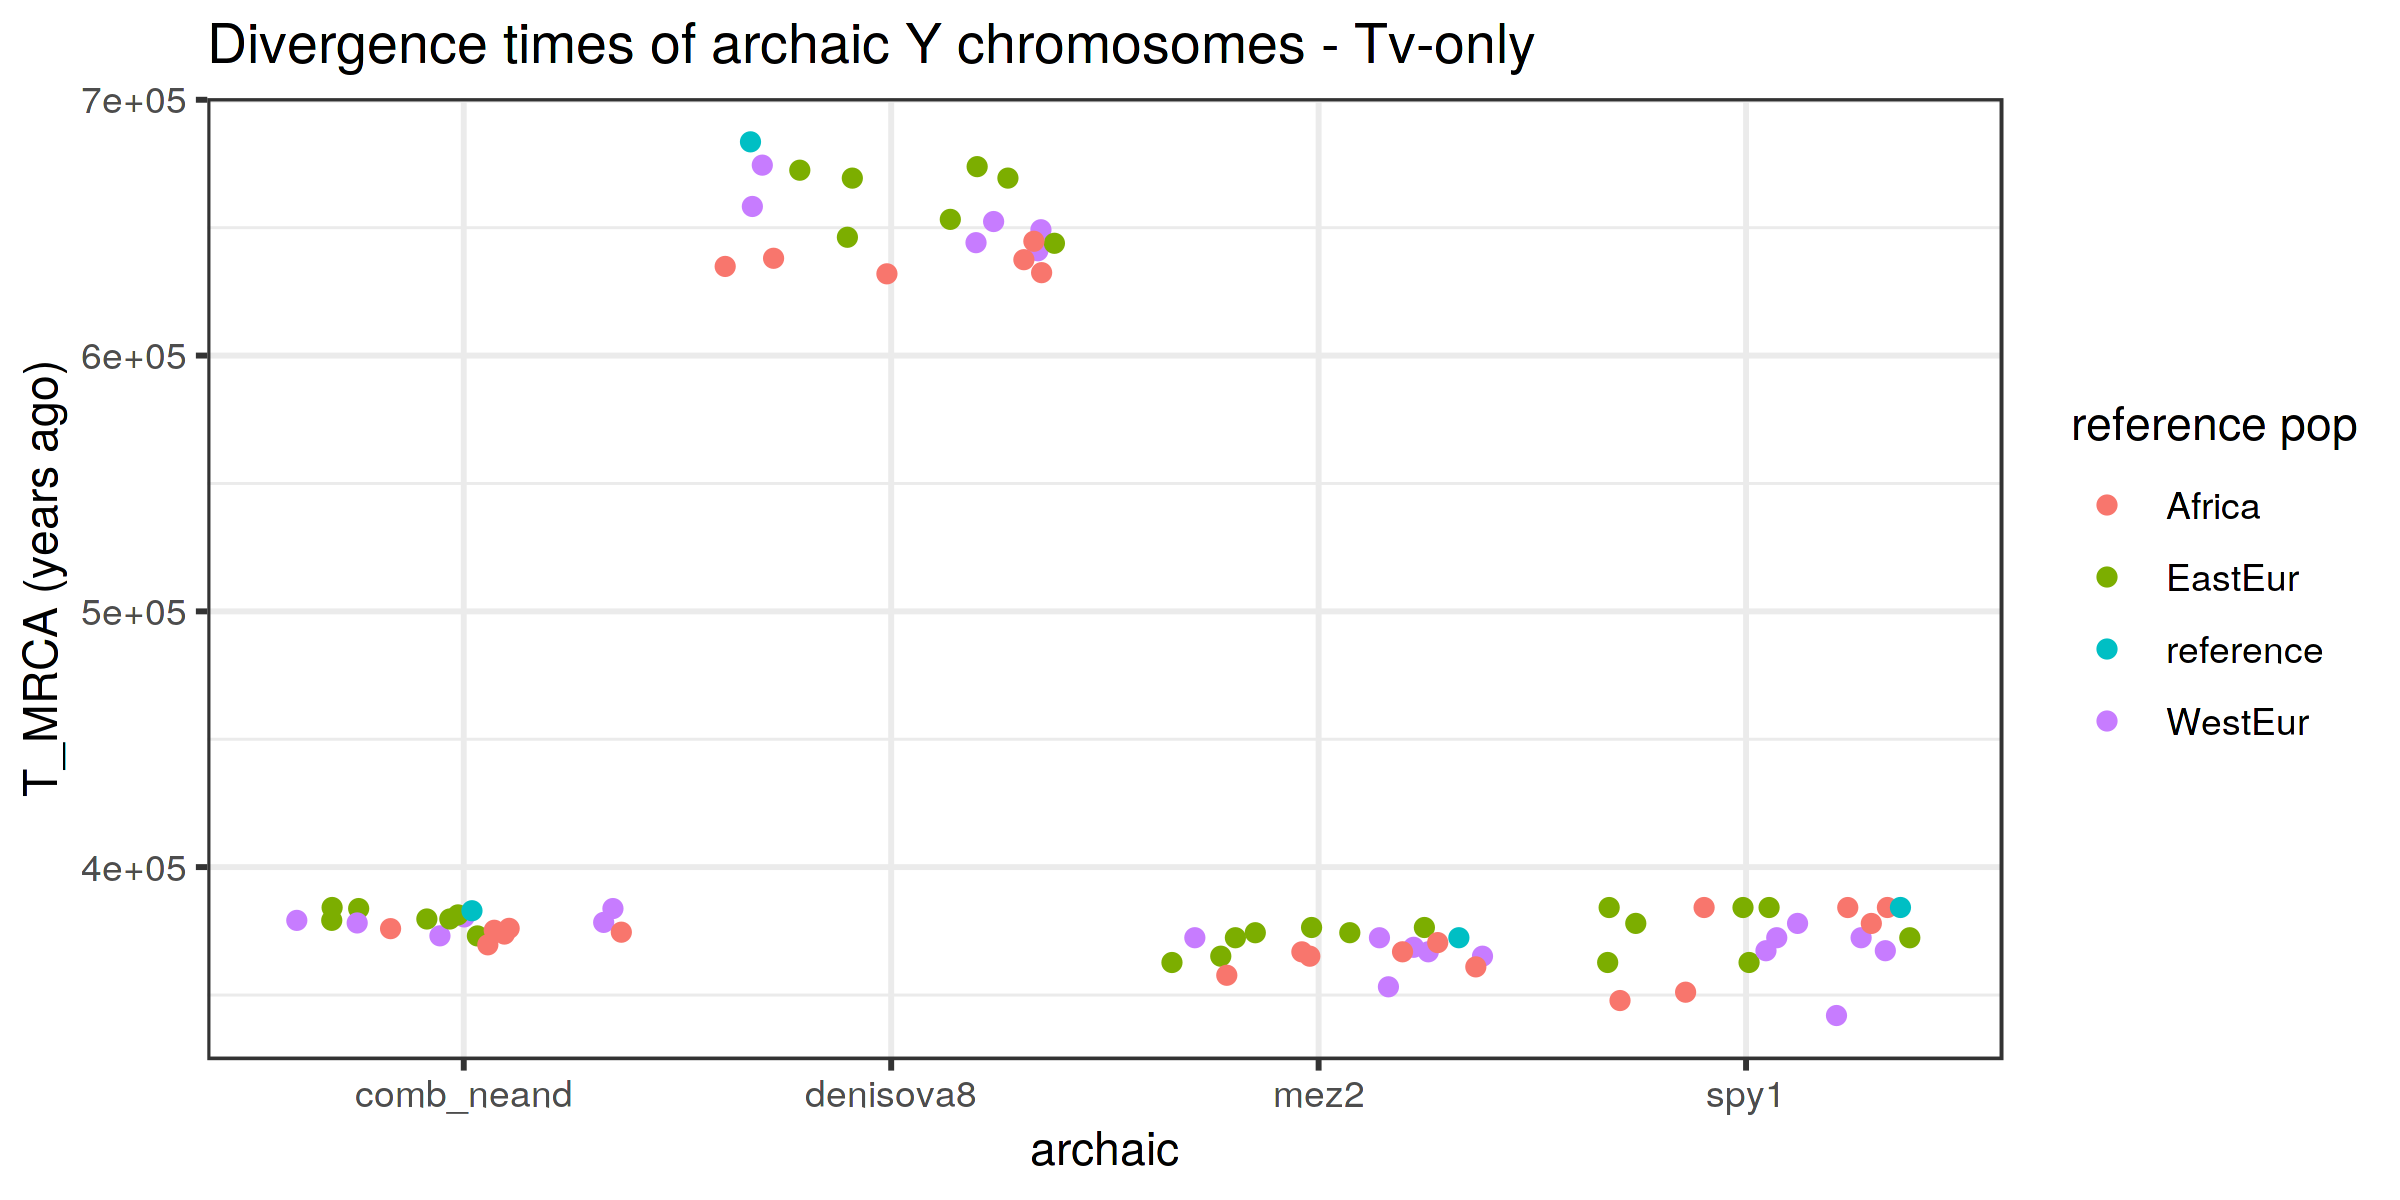

In [22]:
set_dim(8, 4, 300)

arch %>%
    ggplot(aes(archaic, tmrca_arch, color = pop)) +
    geom_jitter() +
    ylab("T_MRCA (years ago)") +
    guides(color = guide_legend("reference pop")) +
    ggtitle("Divergence times of archaic Y chromosomes - Tv-only") +
    theme_bw()

Lippold all SNPs - mutation rate and A00 divergence estimated from WGS:

In [46]:
arch %>%
    group_by(archaic) %>%
    summarise_if(is.numeric, mean) %>%
    arrange(tmrca_arch)

archaic,a,d,e,f,total,p,alpha,tmrca_arch
elsidron2,42.65,102.9,67.20,85.1,400990.6,0.2020359,1.507553,433389.4
comb_neand,11.05,23.9,18.75,18.9,120269.4,0.2070237,1.523550,437988.0
denisova8,50.20,49.1,35.50,49.5,237486.9,0.3739604,2.199577,632331.4


Lippold all SNPs:

In [17]:
arch %>%
    group_by(archaic) %>%
    summarise_if(is.numeric, mean) %>%
    arrange(tmrca_arch)

archaic,a,d,e,f,total,p,alpha,tmrca_arch
elsidron2,42.65,102.9,67.20,85.1,400990.6,0.2020359,1.507553,177380.6
comb_neand,11.05,23.9,18.75,18.9,120269.4,0.2070237,1.523550,179262.7
denisova8,50.20,49.1,35.50,49.5,237486.9,0.3739604,2.199577,258804.9


In [33]:
mendez_a00_counts <- tibble(
    a = 1434, d = 305, e = 19, f = 1591,
    total = 7830000,
    ref = "reference", emh = "ustishim", age = 45000
)

In [34]:
mendez_a00_counts %>%
    mutate(
        muts_per_year = (d - e) / age,
        mut_rate = muts_per_year / total,
        tmrca_ad = (a + d) / (mut_rate * total),
        tmrca_f = f / (mut_rate * total),
        tmrca_avg = (tmrca_ad + tmrca_f) / 2,
        tmrca_ratio = tmrca_ad / tmrca_f
    )

a,d,e,f,total,ref,emh,age,muts_per_year,mut_rate,tmrca_ad,tmrca_f,tmrca_avg,tmrca_ratio
1434,305,19,1591,7830000,reference,ustishim,45000,0.006355556,8.116929e-10,273618.9,250332.2,261975.5,1.093023
